# Dealing with Few to No Labels

At the start of every project, the first question any data scientist asks? Is there any labelled data? Answer's mostly no or little bit. And on top of client's expectation that our fancy machine learning models should still perform well. One obvious apporach is annotate more data, but this is more expensive if each annotation has to be validated by a domain expert.

Fortunaley there are several methods that are suited for dealing with few to no labels. Like *Zero-shot* in GPT-3 where it perfoms over a diverse range of tasks with a few dozen examples.

In general, the best-performing method will depend upon task, data, how much of the data is labeled. 

*The below picture will guide us through the process of picking the most appropriate method*
![alt](../notes/images/9-dealing-with-few-to-no-labels/technqiques-to-deal-with-less-to-no-labelled-data.png)

Let's walk through this decision tree:

1. Is labeld data available?

Evan a handful of labeled of labeled samples can make a difference with regards to which method works best. If no labeld data is available then we can start with zero-shot learning which often sets a strong baseline to work from.

2. How many labels?

If we lots of labelled training data available then we can use the fine tuning approach used in [notebook 2](../notebooks/2-text-classification.ipynb)

3. Is there unlabeled data available?

If we have a handful of labeled samples it can help immensley if we have access to large amounts ot unlabeled data. If we have access to unlabeled data, we can use it to fine-tune the language model on the domain before training the classifier, or use more sophisticated methods like unsupervised data augmentation(UDA) or uncertainy-aware self-training(UST). If no unlabeled data is available, we can't annotate more data. In this case we can use few-shot learning or use the embeddings from a pretrained language model to perform lookups with a nearest neighbor search.

Int this notebook, we'll work our way through the decision tree by tackling a common problem facing many support teams that use issue trackers like Jira or Github to assist their users: tagging issues with metadata based on the issue's description. These tags define issue type,product causing the issue, responsible team. Automating the process will have an big impact on productivity and enables the support teams to focus on helping the users. In this notebook, we'll use issues associated with a populat open source project: Transformers. Let's now take a look at what information is available in these issues, what is the task and how to get the data.

> **Note:** The methods used in this notebooks will work well for text classification, but other techniques such as data augmentation may be necessary for dealing with more complex tasks like named entity recognition, question answering or summarization.

## Building a Github Issues Tagger

If we navgate to [issues tab](https://github.com/huggingface/transformers/issues) of transformers, we'll have each issues with title, description, set of tags or labels to chracterize the issue. The supervised learning task: given a title, description of an issue, predict one or more labels, this means we are dealing with multlable classification problem. 

*Single issue*
![alt](../notes/images/9-dealing-with-few-to-no-labels/singe-issue.png)

Now we've seen how the Github Issues look like, next let's see how to download and create our dataset.

To grab all repository's issues, we'll use the [GitHub REST API](https://docs.github.com/en/rest?apiVersion=2022-11-28) to poll the [Issues endpoint](https://docs.github.com/en/rest/issues#list-repository-issues). This endpoint returns a list of json objects, with each object contatining, issue, title, description, whether issue is open or close, owho opend it etc.

Since it takes a while to fetch all issues, we'll use the *github-issues-transformers-json* file. Along with `fetch_issues()` function to download them.

> **Note:** The GitHub REST API treats pull requests as issues, so our dataset contains both issues and pull requests. To keep things simple. we'' develop our classifier for both issue types, althoug in practice we can have two seperated classifiers to have more fine-grained control over the model's performance.

In [3]:
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(
    owner="huggingface",
    repo="transformers",
    num_issues=10_000,
    rate_limit=5_000,
):
    batch = []
    all_issues = []
    per_page = 100 # Number of issues to return per page
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"

    for page in tqdm(range(num_pages)):
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues)

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = [] # Flush batch for next time period
            print(f"Reached Github rate limit. Sleeping for one hour...")
            time.sleep(60 * 60 + 1)
    all_issues.extend(batch)
    df = pd.DataFrrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

This function will download all the issues in batches to avoid exceeding GitHub's limit on number of requests per hour. Let's download the file.

### Preparing the data

In [36]:

import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [37]:
df_issues

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,milestone,comments,created_at,updated_at,closed_at,author_association,active_lock_reason,body,performed_via_github_app,pull_request
0,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849568459,MDU6SXNzdWU4NDk1Njg0NTk=,11046,Potential incorrect application of layer norm ...,...,NaN,0,2021-04-03 03:37:32,2021-04-03 03:37:32,NaT,NONE,None,"In BlenderbotSmallDecoder, layer norm is appl...",NaN,None
1,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849544374,MDU6SXNzdWU4NDk1NDQzNzQ=,11045,Multi-GPU seq2seq example evaluation significa...,...,NaN,0,2021-04-03 00:52:24,2021-04-03 00:52:24,NaT,NONE,None,\r\n### Who can help\r\n@patil-suraj @sgugger ...,NaN,None
2,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849529761,MDU6SXNzdWU4NDk1Mjk3NjE=,11044,[DeepSpeed] ZeRO stage 3 integration: getting ...,...,NaN,0,2021-04-02 23:40:42,2021-04-03 00:00:18,NaT,COLLABORATOR,None,"**[This is not yet alive, preparing for the re...",NaN,None
3,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849499734,MDU6SXNzdWU4NDk0OTk3MzQ=,11043,Can't load model to estimater,...,NaN,0,2021-04-02 21:51:44,2021-04-02 21:51:44,NaT,NONE,None,I was trying to follow the Sagemaker instructi...,NaN,None
4,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849274362,MDU6SXNzdWU4NDkyNzQzNjI=,11042,[LXMERT] Unclear what img_tensorize does with ...,...,NaN,0,2021-04-02 15:12:57,2021-04-02 15:15:07,NaT,NONE,None,## Environment info\r\n\r\n- `transformers` ve...,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9925,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/pu...,486208136,MDExOlB1bGxSZXF1ZXN0MzExNzA2NjQ5,1127,DistilBERT,...,NaN,2,2019-08-28 07:34:11,2020-01-09 13:36:31,2019-08-28 14:43:10,MEMBER,None,"Preparing the release for DistilBERT (smaller,...",NaN,{'url': 'https://api.github.com/repos/huggingf...
9926,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,486120054,MDU6SXNzdWU0ODYxMjAwNTQ=,1126,Bert initialization,...,NaN,2,2019-08-28 02:01:59,2019-09-02 06:53:22,2019-09-02 06:53:22,NONE,None,"When I train bert model from scratch, it can n...",NaN,None
9927,https://api.github.com/repos/huggingface/trans...,http

In [38]:
df_issues.iloc[0]

url                         https://api.github.com/repos/huggingface/trans...
repository_url              https://api.github.com/repos/huggingface/trans...
labels_url                  https://api.github.com/repos/huggingface/trans...
comments_url                https://api.github.com/repos/huggingface/trans...
events_url                  https://api.github.com/repos/huggingface/trans...
html_url                    https://github.com/huggingface/transformers/is...
id                                                                  849568459
node_id                                              MDU6SXNzdWU4NDk1Njg0NTk=
number                                                                  11046
title                       Potential incorrect application of layer norm ...
user                        {'login': 'sougata-ub', 'id': 59206549, 'node_...
labels                                                                     []
state                                                           

There are almost 10,000 issues in our dataset, and by looking at df info, we've URLs, IDs, dates, users, title, body as well as labels

In [39]:
# cols needed
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [40]:
df_issues.loc[2, "labels"]

[{'id': 2659267025,
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed',
  'name': 'DeepSpeed',
  'color': '4D34F7',
  'default': False,
  'description': ''}]

The `labels` column is the thing we're interested in, and each row contain a list of JSON objects with metadata about each label.
For our purpose we need only `name` field of each object, let's overwrite the `labels` columns with just the label names:

In [41]:
df_issues["labels"].apply(
    lambda x: [meta["name"] for meta in x]
)[:20]

0              []
1              []
2     [DeepSpeed]
3              []
4              []
5              []
6              []
7              []
8              []
9              []
10             []
11             []
12             []
13             []
14             []
15             []
16             []
17             []
18             []
19             []
Name: labels, dtype: object

In [42]:
df_issues["labels"] = df_issues["labels"].apply(
    lambda x: [meta["name"] for meta in x]
)
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


Now each row in `labels` column is a list of GitHub labels, next let's compute the length of labels to find out out number of labels per issue.

<Axes: >

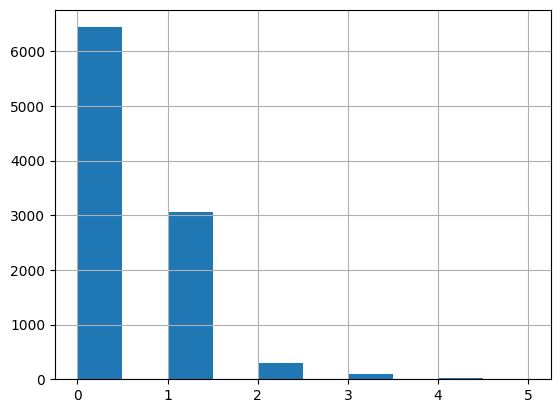

In [43]:
df_issues["labels"].apply(
    lambda x: len(x)
).hist()

More than 60% data has no labels.

In [44]:
df_issues["labels"].apply(
    lambda x: len(x)
).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [45]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
df_counts.to_frame().head(8).T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


In [46]:
df_issues["labels"].explode()

0             NaN
1             NaN
2       DeepSpeed
3             NaN
4             NaN
          ...    
9925          NaN
9926          NaN
9927          NaN
9928          NaN
9929      wontfix
Name: labels, Length: 10522, dtype: object

We can see that there are 65 unique labels in the dataset and the classes are very imbalanced with `wontfix` and `modelcard` being the most common labels. To make the classification problem more traceable, we'll build a tagger on subset of labels that are potentially difficult fo find like `First Issue` and `Help Wanted`, for `model card` a simple rule that detects whena a model card is added on the Hugging Face Hub.

The following code filters the dataset for the subset of labels and simplifies the labels for ease of use.

In [47]:

label_map = {
    "Core: Tokenization": "tokenization",
    "New model": "new model",
    "Core: Modeling": "model training",
    "Usage": "usage",
    "Core: Pipeline": "pipeline",
    "TensorFlow": "tensorflow or tf",
    "PyTorch": "pytorch",
    "Examples": "examples",
    "Documentation": "documentation"
}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [48]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels after label map: {len(df_counts)}")
df_counts.to_frame().T

Number of labels after label map: 9


labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


Let's create a new column to identify whether the issue is labelled or not, which'll be useful later.

In [49]:
df_issues["split"] = "unlabeled"
df_issues.head()

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,comments,created_at,updated_at,closed_at,author_association,active_lock_reason,body,performed_via_github_app,pull_request,split
0,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849568459,MDU6SXNzdWU4NDk1Njg0NTk=,11046,Potential incorrect application of layer norm ...,...,0,2021-04-03 03:37:32,2021-04-03 03:37:32,NaT,NONE,None,"In BlenderbotSmallDecoder, layer norm is appl...",NaN,None,unlabeled
1,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849544374,MDU6SXNzdWU4NDk1NDQzNzQ=,11045,Multi-GPU seq2seq example evaluation significa...,...,0,2021-04-03 00:52:24,2021-04-03 00:52:24,NaT,NONE,None,\r\n### Who can help\r\n@patil-suraj @sgugger ...,NaN,None,unlabeled
2,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849529761,MDU6SXNzdWU4NDk1Mjk3NjE=,11044,[DeepSpeed] ZeRO stage 3 integration: getting ...,...,0,2021-04-02 23:40:42,2021-04-03 00:00:18,NaT,COLLABORATOR,None,"**[This is not yet alive, preparing for the re...",NaN,None,unlabeled
3,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849499734,MDU6SXNzdWU4NDk0OTk3MzQ=,11043,Can't load model to estimater,...,0,2021-04-02 21:51:44,2021-04-02 21:51:44,NaT,NONE,None,I was trying to follow the Sagemaker instructi...,NaN,None,unlabeled
4,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849274362,MDU6SXNzdWU4NDkyNzQzNjI=,11042,[LXMERT] Unclear what img_tensorize does with ...,...,0,2021-04-02 15:12:57,2021-04-02 15:15:07,NaT,NONE,None,## Environment info\r\n\r\n- `transformers` ve...,NaN,None,unlabeled


In [50]:
df_issues["labels"].apply(lambda x: len(x)) > 0

0       False
1       False
2       False
3       False
4       False
        ...  
9925    False
9926    False
9927    False
9928    False
9929    False
Name: labels, Length: 9930, dtype: bool

In [51]:
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [52]:
# Let's check a single sample
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In this example, a new model architecture is proposed, so the label `new model` makes sense. title also has some useful information, let's concatenate title with body field:

In [54]:
df_issues["text"] = df_issues.apply(
    lambda x: x["title"] + "\n\n" + x["body"], axis=1
)

In [55]:
df_issues[["text", "title", "body"]].head()

,text,title,body
0,Potential incorrect application of layer norm ...,Potential incorrect application of layer norm ...,"In BlenderbotSmallDecoder, layer norm is appl..."
1,Multi-GPU seq2seq example evaluation significa...,Multi-GPU seq2seq example evaluation significa...,\r\n### Who can help\r\n@patil-suraj @sgugger ...
2,[DeepSpeed] ZeRO stage 3 integration: getting ...,[DeepSpeed] ZeRO stage 3 integration: getting ...,"**[This is not yet alive, preparing for the re..."
3,Can't load model to estimater\n\nI was trying ...,Can't load model to estimater,I was trying to follow the Sagemaker instructi...
4,[LXMERT] Unclear what img_tensorize does with ...,[LXMERT] Unclear what img_tensorize does with ...,## Environment info\r\n\r\n- `transformers` ve...


Before looking at rest of the data, let's remove the duplicates.

In [56]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before - len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


We've removed few duplicate issues in our dataset, but that's only a small percentage. Next let's take a look at the distribution of words to see if we'll loose much information when we truncate to each model's context size:

Text(0, 0.5, 'Number of issues')

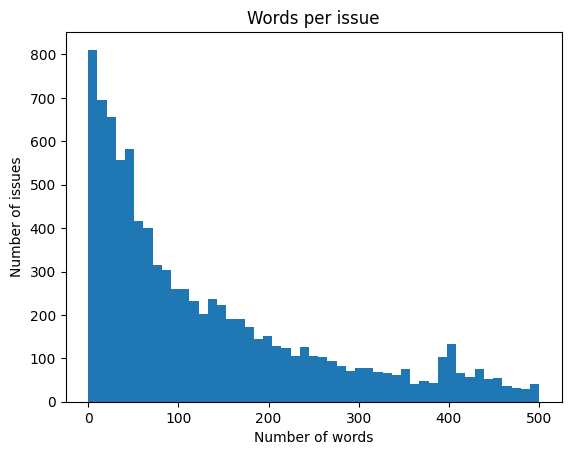

In [57]:
import numpy as np
import matplotlib.pyplot as plt

df_issues["text"].str.split().apply(len).hist(
    bins=np.linspace(0, 500, 50), grid=False
)
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")

The distribution has the long tail characterstic of most text datasets. Most of the texts are fairly short, few texts are over 500 words these might include code, logs, errors etc. Transformer models have a context sixe of 512 tokens or larger, truncating a handful of long issues is not likely to affect the overall performance. Next let's define our training and validation set.